In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [19]:
#I downloaded the data set from https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

df = pd.read_csv('amazon_reviews/Reviews.csv')

# for testing
df = df.head(500)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    int64 
 1   ProductId               500 non-null    object
 2   UserId                  500 non-null    object
 3   ProfileName             500 non-null    object
 4   HelpfulnessNumerator    500 non-null    int64 
 5   HelpfulnessDenominator  500 non-null    int64 
 6   Score                   500 non-null    int64 
 7   Time                    500 non-null    int64 
 8   Summary                 500 non-null    object
 9   Text                    500 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.2+ KB


### Some Data Analysis

Text(0, 0.5, 'Count')

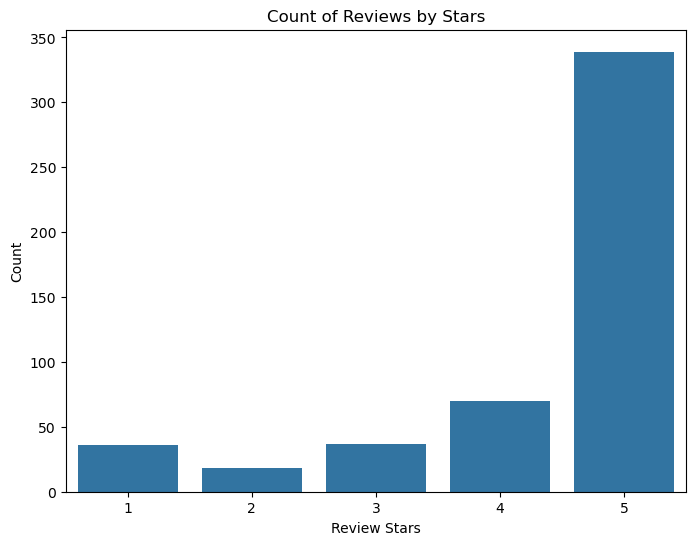

In [21]:
plt.figure(figsize=(8, 6))
sns.barplot(df.Score.value_counts().sort_index())
plt.title("Count of Reviews by Stars")
plt.xlabel("Review Stars")
plt.ylabel("Count")

## Using VADER sentiment scoring

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
# Running polarity score on the dataset

polarity_score = {}

for i, data in tqdm(df.iterrows(), total=len(df)):
    review_text = data['Text']
    review_id = data['Id']
    polarity_score[review_id] = sia.polarity_scores(review_text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
polarity_score

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441},
 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664},
 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265},
 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468},
 6: {'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883},
 7: {'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346},
 8: {'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487},
 9: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369},
 10: {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313},
 11: {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746},
 12: {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'compound': -0.7579},
 13: {'neg': 0.031, 'neu': 0.923, 'pos': 0.046, 'compound': 0.296},
 14: {'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.9466},
 15: {'neg': 0.104, 'neu': 0.632, 'pos': 0.264, 'compound': 0.6486},
 